In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
import torch

# Load tokenizer and pretrained model config
model_path = '../Model/sentiment_bert'
tokenizer = BertTokenizer.from_pretrained(model_path)

# Enable output of hidden states for RL training later
config = BertConfig.from_pretrained(model_path, output_hidden_states=True)
bert_model = BertForSequenceClassification.from_pretrained(model_path, config=config)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

print("Model loaded. Using device:", device)


Model loaded. Using device: cuda


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# A simple MLP-based policy network that takes [CLS] embeddings as input
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, output_dim=5):  # 5 classes in sentiment
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim=-1)

policy_net = PolicyNetwork().to(device)


In [4]:
import pandas as pd

# Load preprocessed training data
train_data = pd.read_csv("../Dataset/train_preprocessed.csv")
texts = train_data["Phrase"].astype(str).tolist()
labels = train_data["Sentiment"].tolist()


In [5]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return encoded['input_ids'].squeeze(), encoded['attention_mask'].squeeze(), self.labels[idx]

# Prepare PyTorch DataLoader
dataset = TextDataset(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [6]:
# First stage: Supervised learning with CrossEntropyLoss
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 5
losses = []
accuracies = []

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0

    for input_ids, attention_mask, labels in dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = torch.tensor(labels).to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.hidden_states[-1][:, 0, :].detach()  # [CLS] token

        logits = policy_net(cls_embeddings)
        loss = loss_fn(logits, labels)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += len(labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    acc = correct / total
    losses.append(total_loss)
    accuracies.append(acc)
    print(f"[Supervised Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


C:\Users\jsj31\AppData\Local\Temp\ipykernel_19512\3271188630.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


KeyboardInterrupt: 

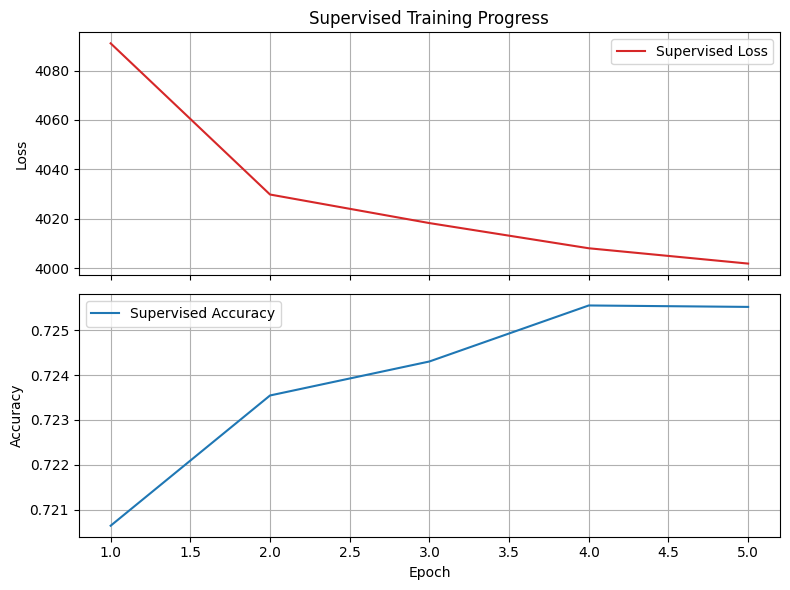

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot loss
axs[0].plot(range(1, len(losses)+1), losses, color='tab:red', label='Supervised Loss')
axs[0].set_ylabel('Loss')
axs[0].set_title('Supervised Training Progress')
axs[0].legend()
axs[0].grid(True)

# Plot accuracy
axs[1].plot(range(1, len(accuracies)+1), accuracies, color='tab:blue', label='Supervised Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from torch.distributions import Categorical

# Initialize logging lists
rl_losses = []
rl_accuracies = []

# Optimizer for fine-tuning
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=5e-5)

for epoch in range(3):  # RL fine-tuning
    total_loss = 0
    correct = 0
    total = 0

    for input_ids, attention_mask, labels in dataloader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = torch.tensor(labels).to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.hidden_states[-1][:, 0, :].detach()

        action_probs = torch.exp(policy_net(cls_embeddings))
        dist = Categorical(action_probs)
        actions = dist.sample()

        rewards = torch.where(actions == labels,
                              torch.tensor(2.0, device=device),
                              torch.tensor(-0.2, device=device))
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

        correct += (actions == labels).sum().item()
        total += len(labels)

        log_probs = dist.log_prob(actions)
        loss = -(log_probs * rewards).mean()

        policy_optimizer.zero_grad()
        loss.backward()
        policy_optimizer.step()

        total_loss += loss.item()

    acc = correct / total
    rl_losses.append(total_loss)
    rl_accuracies.append(acc)

    print(f"[RL Epoch {epoch+1}] Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")


C:\Users\jsj31\AppData\Local\Temp\ipykernel_21224\3940844417.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


[RL Epoch 1] Loss: -685.6365, Accuracy: 0.7111
[RL Epoch 2] Loss: -367.6629, Accuracy: 0.7193
[RL Epoch 3] Loss: -289.8791, Accuracy: 0.7217


In [ ]:
# Save supervised version of the policy network
supervised_path = "../Model/policy_net_supervised.pt"
torch.save(policy_net.state_dict(), supervised_path)
print(f"[✓] Supervised policy network saved to {supervised_path}")

# Save fine-tuned version (after RL) of the policy network
rl_path = "../Model/policy_net_rl.pt"
torch.save(policy_net.state_dict(), rl_path)
print(f"[✓] RL fine-tuned policy network saved to {rl_path}")


[✓] Supervised policy network saved to ../Model/policy_net_supervised.pt
[✓] RL fine-tuned policy network saved to ../Model/policy_net_rl.pt


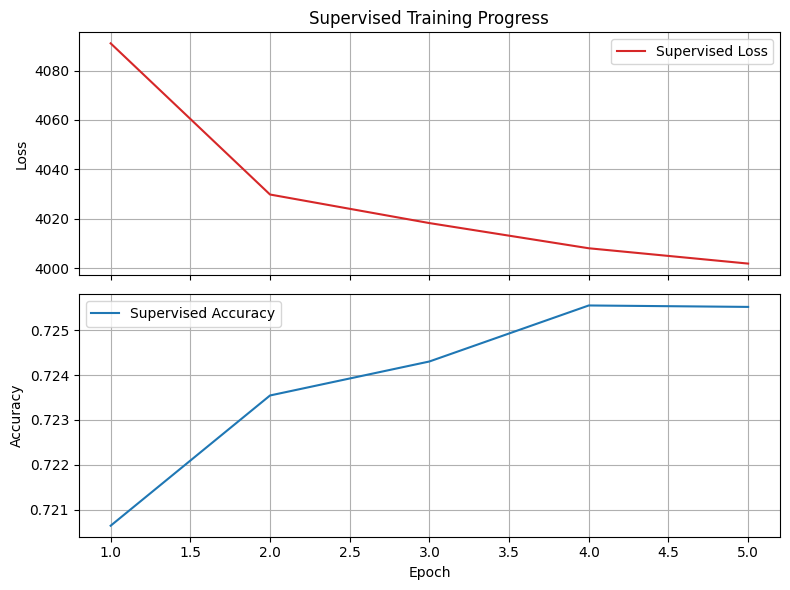

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Plot RL loss
axs[0].plot(range(1, len(rl_losses)+1), rl_losses, color='tab:orange', label='RL Loss')
axs[0].set_ylabel('Loss')
axs[0].set_title('RL Fine-tuning Progress')
axs[0].legend()
axs[0].grid(True)

# Plot RL accuracy
axs[1].plot(range(1, len(rl_accuracies)+1), rl_accuracies, color='tab:green', label='RL Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

true_labels = []
bert_preds = []

bert_model.eval()
for input_ids, attention_mask, labels in dataloader:
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = torch.tensor(labels).to(device)

    with torch.no_grad():
        output = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pred = output.logits.argmax(dim=1)

    bert_preds.extend(pred.cpu().tolist())
    true_labels.extend(labels.cpu().tolist())

original_acc = accuracy_score(true_labels, bert_preds)
print(f"Original BERT accuracy (no RL): {original_acc:.4f}")


C:\Users\jsj31\AppData\Local\Temp\ipykernel_21224\3113694984.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Original BERT accuracy (no RL): 0.7103
